# GROBID evaluation

This notebook is used to evaluate the accuracy of GROBID's affiliation parsing capabilities. It compares the predictions of the GROBID API with the ground truth author and affiliation data, along with predictions made using other strategies.

Ground truth authors and affiliations were cataloged by hand using SHROOM, and are downloaded as Cocina from SDR by the `preprints:download` task (see README.md). This needs to be run prior to running this notebook.

A GROBID server needs to be running locally and available at port 8070 to make the predictions. On an ARM64 Mac, you can do this using Docker with:
```sh
docker run --rm --init --ulimit core=0 -p 8070:8070 --platform linux/amd64 lfoppiano/grobid:latest-crf
```

If predictions have already been saved to the `output/grobid` folder, those will be loaded and used instead.

In [5]:
# set up project root path for imports
import sys
import os
import pathlib
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PROJECT_ROOT = pathlib.Path(root)

# make scripts in scripts/ importable and import util functions
sys.path.insert(1, str(PROJECT_ROOT / 'scripts'))
from notebook_utils import get_gold_affiliations

# set up data table with columns for gold and predicted affiliations
import pandas as pd
preprints = pd.read_csv(PROJECT_ROOT / 'assets' / 'preprints.csv')
preprints['gold'] = ''
preprints['pred'] = ''

# add the gold affiliations to the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    preprint_file = PROJECT_ROOT / "assets" / "preprints" / "pdf" / f"{preprint_id}.pdf"
    preprints.at[i, 'file'] = preprint_file
    preprints.at[i, 'gold'] = get_gold_affiliations(preprint_id)
    
# keep only the columns we need
preprints = preprints[['OpenAlex ID', 'DRUID', 'file', 'pred', 'gold']]

# limit to only rows where we have gold affiliations
preprints = preprints[preprints['gold'] != '']
print("loaded gold affiliations for", len(preprints), "preprints")

loaded gold affiliations for 100 preprints


In [6]:
from notebook_utils import RESULTS_PATH, get_grobid_prediction, load_predictions_xml
from tqdm.notebook import tqdm

# set this and run cell to force re-running predictions
FORCE_RERUN = True

# if we don't have any saved predictions, run prediction for every preprint
grobid_results_path = RESULTS_PATH / "grobid"
predictions = load_predictions_xml(grobid_results_path)
if not predictions or FORCE_RERUN:
    print("No predictions found, running prediction for all preprints")
    for i, row in tqdm(preprints.iterrows(), total=len(preprints), desc="Predicting"):
        preprint_file = row['file']
        get_grobid_prediction(preprint_file, grobid_results_path)
    predictions = load_predictions_xml(grobid_results_path)
else:
    print("Using saved predictions")

# set predictions for each preprint in the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    if preprint_id in predictions:
        preprints.at[i, 'pred'] = predictions[preprint_id]
print("loaded predictions for", len(preprints), "preprints")

No predictions found, running prediction for all preprints


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

loaded predictions for 100 preprints


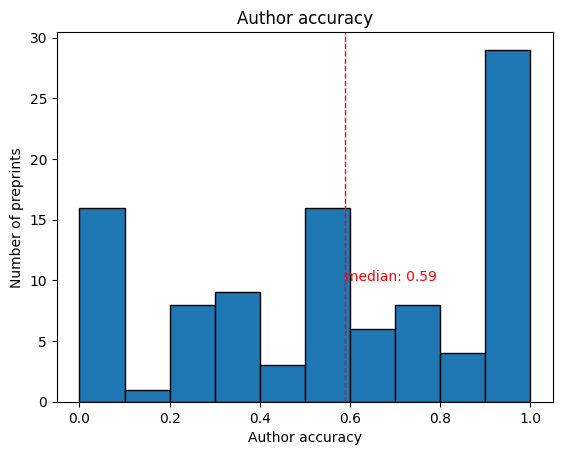

In [7]:
# calculate some accuracy statistics for authors
for i, row in preprints.iterrows():
    gold = row.gold
    pred = row.pred
    correct = 0
    total = 0
    for author in gold:
        total += 1
        if author in pred:
            correct += 1
    preprints.at[i, 'authors_accuracy'] = correct / total if total > 0 else (1 if correct == 0 else 0)

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
author_acc = preprints['authors_accuracy']
author_acc_median = author_acc.median()
plt.hist(author_acc, edgecolor='black')
plt.xlabel('Author accuracy')
plt.ylabel('Number of preprints')
plt.title('Author accuracy')
plt.axvline(author_acc_median, color='r', linestyle='dashed', linewidth=1) 
plt.text(author_acc_median, 10, f'median: {author_acc_median:.2f}', color='r')
plt.show()

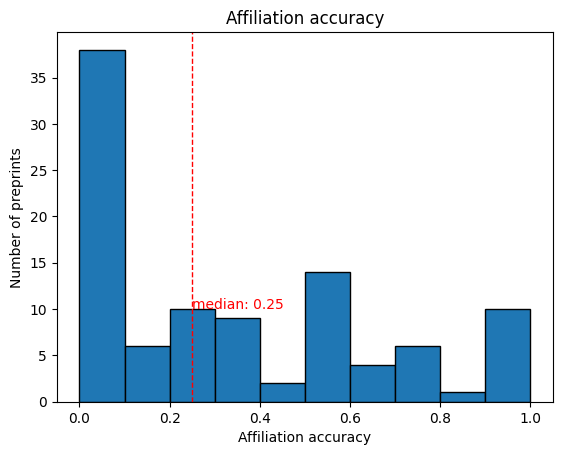

In [8]:
# calculate some accuracy statistics for affiliations
for i, row in preprints.iterrows():
    gold = row.gold
    pred = row.pred
    correct = 0
    total = 0
    for author in gold:
        for affiliation in gold[author]:
            total += 1
            if author in pred and affiliation in pred[author]:
                correct += 1
    preprints.at[i, 'affiliations_accuracy'] = correct / total if total > 0 else (1 if correct == 0 else 0)

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
affil_acc = preprints['affiliations_accuracy']
affil_acc_median = affil_acc.median()
plt.hist(affil_acc, edgecolor='black')
plt.xlabel('Affiliation accuracy')
plt.ylabel('Number of preprints')
plt.title('Affiliation accuracy')
plt.axvline(affil_acc_median, color='r', linestyle='dashed', linewidth=1)
plt.text(affil_acc_median, 10, f'median: {affil_acc_median:.2f}', color='r')
plt.show()
